测试强制接管动作与：
- 约束强化学习（Constrained RL — e.g. Lagrangian 方法）
- 屏蔽强化学习（Shielded RL / runtime shield）

| 方法                               | 核心支持文献                                                                                          |
| -------------------------------- | ----------------------------------------------------------------------------------------------- |
| **Constrained RL（Lagrangian 等）** | FAC｜Constrained Variational PO｜ACIL｜Lyapunov RL｜BLAC｜Model-based Constrained PPO｜PID Lagrangian |
| **Shielded RL**                  | Safe RL via Shielding (AAAI18)｜Online Shielding｜Hybrid Systems Shielding｜Sim-to-Lab-to-Real     |
| **Risk-Constrained PG**          | Distributional safety critic (SAC)；社区讨论支持                                                       |


动作屏蔽方法(最简单实现)：
s->Actor->a_raw->规则限制->a_exec->env.step(a_exec)->r,s', 
- Actor与Critic都根据s,a_exec,r,s'更新，训练和执行都带着规则限制

#### PPO 无接管

Iteration: 100%|██████████| 200/200 [00:07<00:00, 27.88it/s, episode=200, return=17.374]


Text(0, 0.5, 'Returns')

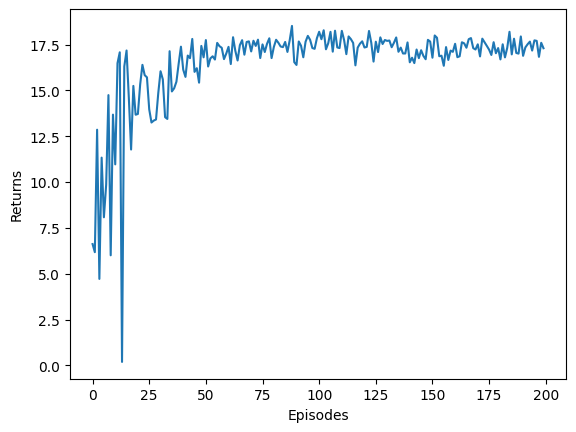

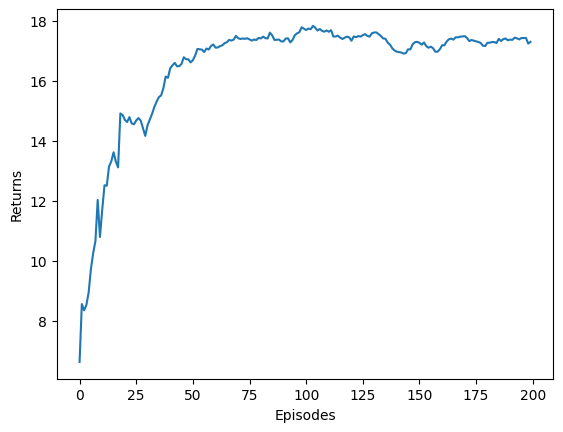

In [20]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.use('Qt5Agg')  # 使用Qt5作为后端

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move # + np.random.normal()
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return 0 # -3

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.PPOcontinues import *

# 超参数
actor_lr = 1e-3 /10 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200 # fixme 500 的时候会梯度爆炸
hidden_dims = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10 # fixme 4的时候也会梯度爆炸
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = []
clear_batch_flag=1
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        if clear_batch_flag:
            transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
            clear_batch_flag=0
        state = env.reset()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action = agent.take_action(state, action_bound=action_bound, explore=True)
            next_state, reward, done = env.step(action)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        if 1: # len(transition_dict['dones'])>20: # 逐batch更新
            agent.update(transition_dict, action_bound)
            clear_batch_flag=1
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))



#### PPO+接管（爆炸）

简单给PPO加接管会导致前后策略分布估计差异过大，从而梯度爆炸

Iteration: 100%|██████████| 200/200 [00:07<00:00, 28.15it/s, episode=200, return=4.547] 


Text(0, 0.5, 'Returns')

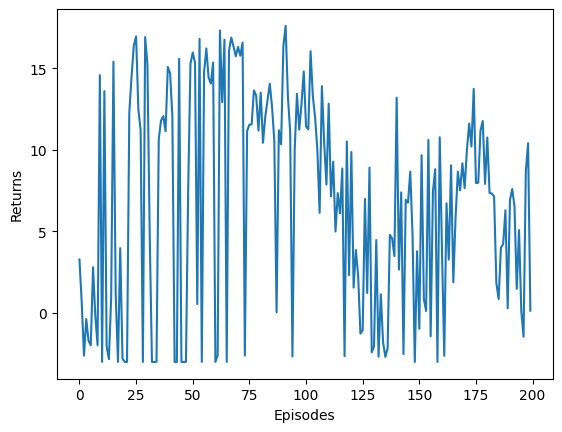

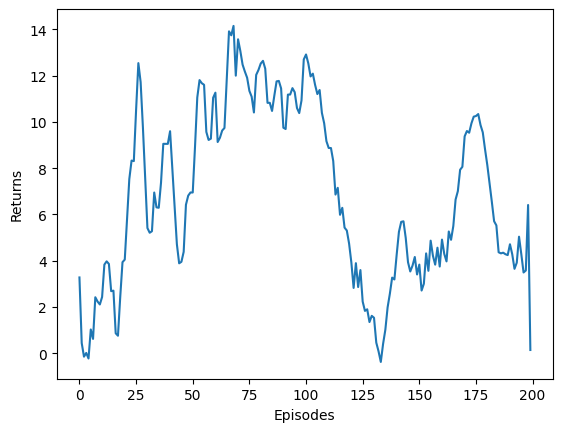

In [10]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return -3

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.PPOcontinues_special_test import *

# 超参数
actor_lr = 1e-4 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 500 # 500  # 2000
hidden_dims = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = []
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        env.reset()
        state = env.get_obs()
        # print(state)
        
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action_raw = agent.take_action(state, action_bound=action_bound, explore=True)
            
            # 接管
            action_exec = action_raw
            # print(action_exec)
            # if state[0]>7:
            #     action_exec[0]=min(0*action_exec[0], action_exec[0])
            # if state[0]<-7:
            #     action_exec[0]=max(0*action_exec[0]/2, action_exec[0])

            next_state, reward, done = env.step(action_exec)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action_exec) # action_exec action_raw
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        agent.update(transition_dict, action_bound)
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))



#### SAC 有/无接管

改用SAC，直接使用替代动作存经验池的话调参很玄学

Iteration: 100%|██████████| 400/400 [00:04<00:00, 89.05it/s, episode=400, return=14.761]


Text(0, 0.5, 'Returns')

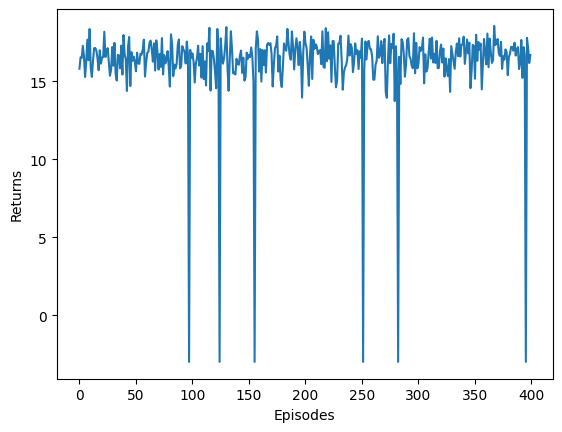

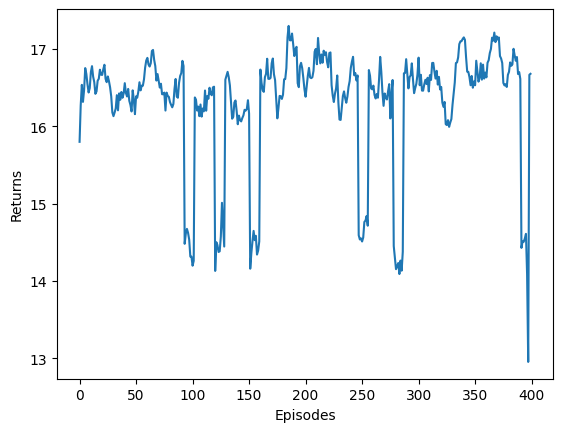

In [2]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return -3

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.SACcontinues import *

# 超参数
actor_lr = 8e-5 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 400  # 2000
hidden_dims = [128]  # 128
gamma = 0.9
alpha_lr = 3e-4
tau = 0.005  # 软更新参数
buffer_size = 40
minimal_size = 40  # 1000
batch_size = minimal_size
sigma = 0.01  # 0.01  # 高斯噪声标准差

eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
replay_buffer = ReplayBuffer(buffer_size)
# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
target_entropy=-1 # -env.action_space.shape[0]

agent = SACContinuous(state_dim, hidden_dims, action_dim,
                      actor_lr, critic_lr, alpha_lr, target_entropy, tau,
                      gamma, device)

return_list = []
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        env.reset()
        state = env.get_obs()
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action_raw = agent.take_action(state, action_bound=action_bound, explore=True)
            
            
            action_exec = action_raw
            # # 接管
            # # print(action_exec)
            # if state[0]>7:
            #     action_exec[0]=min(0*action_exec[0], action_exec[0])
            # if state[0]<-7:
            #     action_exec[0]=max(0*action_exec[0], action_exec[0])

            next_state, reward, done = env.step(action_exec)  # pendulum中的action一定要是ndarray才能输入吗？
            # 2.运行记录添加回放池

            replay_buffer.add(state, action_exec, reward, next_state, done)
            state = next_state
            episode_return += reward

            # 3.从回放池采样更新智能体
            if replay_buffer.size() > minimal_size:
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                agent.update(transition_dict)

        return_list.append(episode_return)
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))



#### 模仿学习

Iteration: 100%|██████████| 200/200 [00:02<00:00, 93.28it/s, episode=200]


Text(0, 0.5, 'Returns')

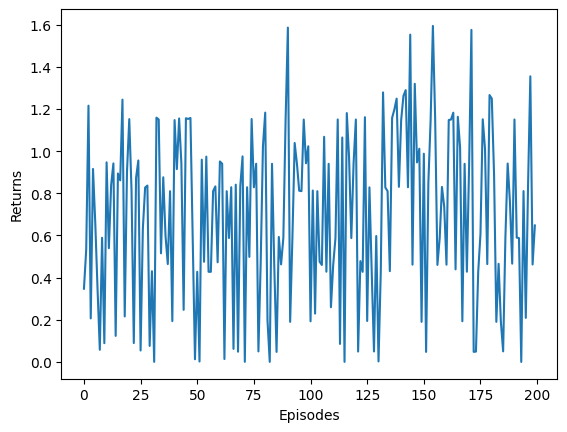

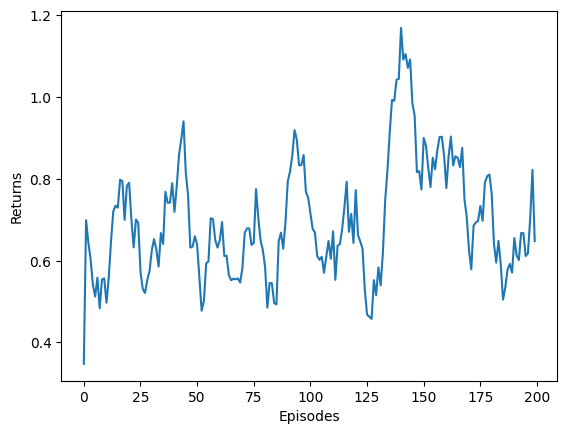

In [11]:
# 游标训练环境
import random
import matplotlib.pyplot as plt
import matplotlib

class Env:
    def __init__(self):
        self.min_pos = -10
        self.max_pos = 10
        self.position = None

    def reset(self):
        self.position = np.array([random.randint(self.min_pos, self.max_pos)],dtype='float64')
        self.steps=0
        return self.get_obs()

    def get_obs(self):
        return self.position

    def step(self, move):
        self.position += move
        self.steps+=1
        done = self.get_done()
        reward = self.get_reward()
        # print(reward)
        return self.get_obs(), reward, done

    def get_done(self):
        done=0
        if self.position < self.min_pos or self.position > self.max_pos:
            done=1
        if self.steps>=20:
            done=1
        return done

    def get_reward(self):
        if self.min_pos <= self.position <= self.max_pos:
            return 1-np.linalg.norm(self.position-(self.max_pos+self.min_pos)/2)/10
        else:
            return -3
    def teach(self):
        teach_action_mu=np.clip((self.max_pos+self.min_pos)/2-self.position, -action_bound, action_bound)
        teach_action_std=action_bound*0.3
        return teach_action_mu, teach_action_std
    

import sys
import os
sys.path.append(os.path.abspath(".."))

from Algorithms.PPOcontinues import *

# 超参数
actor_lr = 8e-5 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200  # 2000
hidden_dims = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
actor = PolicyNetContinuous(state_dim, hidden_dims, action_dim)

loss_list=[]
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        env.reset()
        state = env.get_obs()
        # print(state)
        
        done = False
        while not done:  # 每个训练回合
            mu_teach, std_teach = env.teach()
            
            # 接管
            action_exec = mu_teach

            next_state, reward, done = env.step(action_exec) 
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action_exec) # action_exec action_raw
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
        
        # 有监督学习
        import torch.optim as optim
        loss_func = nn.MSELoss()
        optimizer = optim.Adam(actor.parameters(), lr=0.01)

        states=transition_dict['states']
        states = np.array(states)
        states = torch.tensor(states, dtype=torch.float)
        teach_actions = transition_dict['actions']
        teach_actions=np.array(teach_actions)
        teach_actions = torch.tensor(teach_actions, dtype=torch.float)

        losses = 0
        for epoch in range(epochs):
            optimizer.zero_grad()
            mu, sigma = actor(states, action_bound=action_bound)
            loss = loss_func(mu, teach_actions)
            loss.backward()
            optimizer.step()
            losses+=loss.item()/epochs

        loss_list.append(loss.item())

        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),})
        pbar.update(1)
    # return return_list

%matplotlib inline

episodes_list = list(range(len(loss_list)))
plt.figure()
plt.plot(episodes_list, loss_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(loss_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


[-3.]


Text(0, 0.5, 'state')

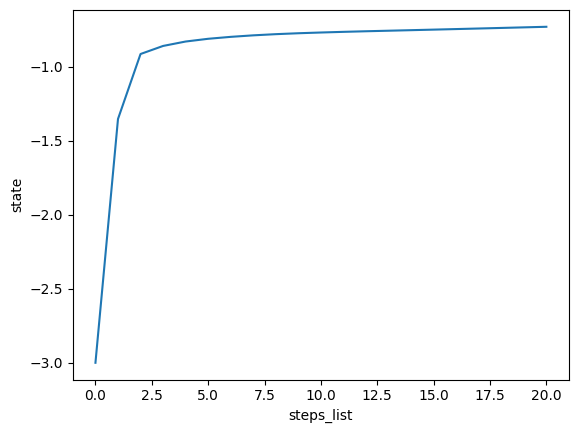

In [32]:

# 测试
env.reset()
state = env.get_obs()
print(state)

done = False
state_list=[state.copy()]

while not done:  # 每个训练回合
    
    # Actor动作
    state = np.array(state)
    state = torch.tensor(state, dtype=torch.float)
    mu, sigma = actor(state, action_bound=action_bound)
    action_exec = mu.detach().cpu().numpy()
    
    # # 教练动作
    # mu_teach, std_teach = env.teach()
    # action_exec = mu_teach
    
    next_state, reward, done = env.step(action_exec)
    state_list.append(next_state.copy())
    state = next_state

# print('state_list',state_list)

steps_list = list(range(len(state_list)))
plt.figure()
plt.plot(steps_list, state_list)
plt.xlabel('steps_list')
plt.ylabel('state')

#### shield与有监督学习插入强化学习

In [ ]:
import random
import gym
import numpy as np
from tqdm import tqdm
import collections
import torch
from torch import nn
import torch.nn.functional as F

from gym import spaces
from numpy.linalg import norm
from torch.distributions import Normal




def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0))
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size - 1, 2)
    begin = np.cumsum(a[:window_size - 1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        # self.prelu = torch.nn.PReLU()

        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(torch.nn.Linear(prev_size, layer_size))
            # layers.append(self.prelu)
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_out = torch.nn.Linear(prev_size, 1)  # todo 补充多维输出

        # # 添加参数初始化
        # for layer in self.net:
        #     if isinstance(layer, nn.Linear):
        #         torch.nn.init.xavier_normal_(layer.weight, gain=0.01)
        # torch.nn.init.xavier_normal_(self.fc_out.weight, gain=0.01)

    def forward(self, x):
        y = self.net(x)
        return self.fc_out(y)

class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        # self.prelu = torch.nn.PReLU()
        layers = []
        prev_size = state_dim
        for layer_size in hidden_dim:
            layers.append(nn.Linear(prev_size, layer_size))
            # layers.append(self.prelu)
            layers.append(nn.ReLU())
            prev_size = layer_size
        self.net = nn.Sequential(*layers)
        self.fc_mu = torch.nn.Linear(prev_size, action_dim)
        self.fc_std = torch.nn.Linear(prev_size, action_dim)
        # # 固定神经网络初始化参数
        # torch.nn.init.xavier_normal_(self.fc_mu.weight, gain=0.01)
        # torch.nn.init.xavier_normal_(self.fc_std.weight, gain=0.01)

    def forward(self, x, action_bound=2.0):
        x = self.net(x)
        mu = action_bound * torch.tanh(self.fc_mu(x))
        std = action_bound * F.softplus(self.fc_std(x))  # + 1e-8
        return mu, std

class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)

        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state, action_bound=2.0, explore=True):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state, action_bound=action_bound)
        if not explore:
            action = mu
            return action[0].cpu().detach().numpy().flatten()  # 支持一维和多维动作，而不是.item只支持1维或.squeeze只支持多维
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return action[0].cpu().detach().numpy().flatten()  # 支持一维和多维动作，而不是.item只支持1维或.squeeze只支持多维
        # return [action.item()]

    def update(self, transition_dict, action_bound):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        # actions = torch.tensor(transition_dict['actions'],
        #                        dtype=torch.float).view(-1, 1).to(self.device)
        # fixme actions不适合flatten
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        
        mu, std = self.actor(states, action_bound=action_bound)  # 均值、方差
        # 添加Actor NaN检查
        if torch.isnan(mu).any() or torch.isnan(std).any():
            raise ValueError("NaN in Actor outputs before loop")
        # 添加Critic NaN检查
        critic_values = self.critic(states)
        if torch.isnan(critic_values).any():
            raise ValueError("NaN in Critic outputs before loop")

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)  # 时序差分回报值
        td_delta = td_target - self.critic(states)  # 优势函数用时序差分回报与Critic网络输出作差表示
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu(), dones.cpu()).to(self.device)

        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        if torch.isnan(old_log_probs).any():
            raise ValueError("替代动作无法被转换")

        for _ in range(self.epochs):
            mu, std = self.actor(states, action_bound=action_bound)
            # 添加Actor NaN检查
            if torch.isnan(mu).any() or torch.isnan(std).any():
                raise ValueError("NaN in Actor outputs in loop")
            critic_values = self.critic(states)
            # 添加Critic NaN检查
            if torch.isnan(critic_values).any():
                raise ValueError("NaN in Critic outputs in loop")

            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            
            ratio = torch.exp(log_probs - old_log_probs)

            # print(ratio)

            # # 添加KL检查
            # approx_kl = (old_log_probs - log_probs).mean()
            # test = 0.02
            # if abs(approx_kl) > test:
            #     # print('approx_kl',approx_kl) # 这个好像绝对值大于1就会有问题
            #     ratio = torch.exp((log_probs - old_log_probs) / abs(approx_kl) * test)
            #     # print('ratio', ratio)  # 这个好像绝对值大于1就会有问题

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            # actor_loss = torch.mean(-torch.min(surr1, surr2)) # original
            actor_loss = torch.sum(torch.min(surr1,surr2),dim=-1,keepdim=True) # test
            # print(actor_loss)
            actor_loss = -actor_loss.mean()

            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()

            # 梯度裁剪
            nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=2)
            nn.utils.clip_grad_norm_(self.critic.parameters(), max_norm=2)

            self.actor_optimizer.step()
            self.critic_optimizer.step()

# 超参数
actor_lr = 8e-5 # 1e-4 1e-6  # 2e-5 警告，学习率过大会出现"nan"
critic_lr = actor_lr * 10  # 1e-3  9e-3  5e-3 为什么critic学习率大于一都不会梯度爆炸？ 为什么设置成1e-5 也会爆炸？ chatgpt说要actor的2~10倍
num_episodes = 200  # 2000
hidden_dims = [128]  # 128
gamma = 0.9
lmbda = 0.9
epochs = 10  # 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# env_name = 'testEnv'
env = Env()
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
state_dim = 1
action_dim = 1
action_bound = 3  # 动作最大值
agent = PPOContinuous(state_dim, hidden_dims, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = []
with tqdm(total=int(num_episodes), desc='Iteration') as pbar:  # 进度条
    for i_episode in range(int(num_episodes)):  # 每个1/10的训练轮次
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        env.reset()
        state = env.get_obs()
        # print(state)
        
        done = False
        while not done:  # 每个训练回合
            # state_check=state
            # 1.执行动作得到环境反馈
            action_raw = agent.take_action(state, action_bound=action_bound, explore=True)
            
            # 接管
            action_exec = action_raw
            # print(action_exec)
            if state[0]>7:
                action_exec[0]=min(0*action_exec[0], action_exec[0])
            if state[0]<-7:
                action_exec[0]=max(0*action_exec[0]/2, action_exec[0])

            next_state, reward, done = env.step(action_exec)  # pendulum中的action一定要是ndarray才能输入吗？
            # print(reward)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action_exec) # action_exec action_raw
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        agent.update(transition_dict, action_bound)
        if (i_episode + 1) >= 10:
            pbar.set_postfix({'episode': '%d' % (i_episode + 1),
                              'return': '%.3f' % np.mean(return_list[-10:])})
        pbar.update(1)
    # return return_list

# return_list = train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size)

%matplotlib inline

episodes_list = list(range(len(return_list)))
plt.figure()
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))


mv_return = moving_average(return_list, 9)
plt.figure()
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
# plt.title('PPO on {}'.format(env_name))
